# Notebook 1: Detecting Sources from Images

Photometry is the measurement of light from astronomical objects. It is the most basic and fundamental measurement in astronomy. In this module, we will cover the basic concepts of photometry starting from handling astronomical images, detecting and measuring sources, and working with photometric catalogs.

## Astronomical images

To measure light from objects, we need to first have an image that contains those objects. Here, we will first read in an image from the JWST NGDEEP survey and plot it out. Astronomical images are usually stored in the fits format. Fits files can contain both the image itself, as well as information about the image in the file "header".

In [221]:
from astropy.io import fits
import numpy as np

import matplotlib.pyplot as plt
from astropy.visualization import ImageNormalize, ZScaleInterval
from matplotlib.patches import Ellipse
from astropy.wcs import WCS
from astropy.table import Table
from matplotlib.colors import LogNorm
from astropy.table import join

%matplotlib notebook 
# The line above makes matplotlib plot interactive
# If you are having a problem with javascript, just comment out this line

### 1. Science image

In [164]:
# Reading in the image and header from the fits file
sci, hdr = fits.getdata('ngdeep_nircam_f277w_bkgsub_sci_cutout.fits.gz', header=True)


<IPython.core.display.Javascript object>


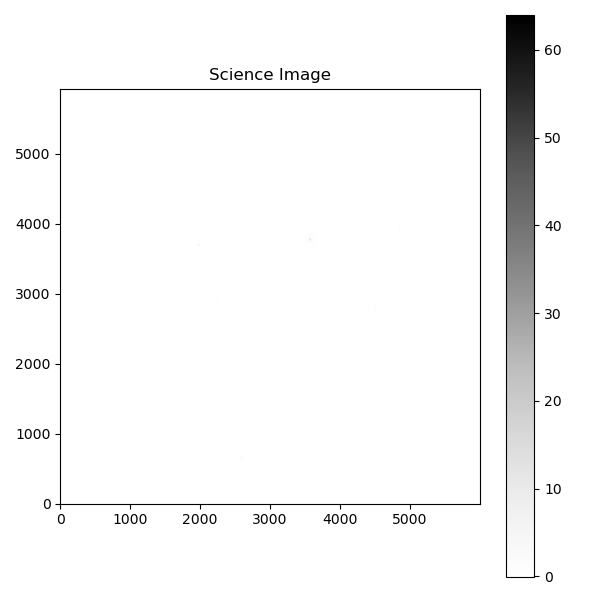

In [217]:
# Making the plot
plt.figure(figsize=(6, 6))
plt.title('Science Image')
plt.imshow(sci, cmap='Greys', origin='lower', interpolation='none')
plt.colorbar()

plt.tight_layout()
plt.show()

Oops! We can't see anything.

The reason is that we haven't set the normalization scaling of the image. The normalization maps the values in the image to different colors. 

Here, we will create a normalization using the "z scale". This scaling is useful in displaying image values near its median. Note the difference in the color bar.

<IPython.core.display.Javascript object>


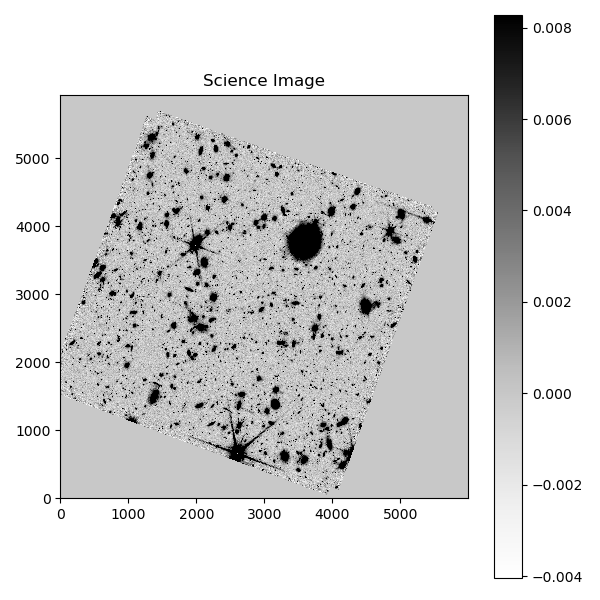

In [220]:
# First, we create a normalization using the z scale to help visualize the image better
# Note that the area outside our pointing has values=0, so we exclude these pixels when
# calculating the normalization
norm = ImageNormalize(sci[sci!=0], interval=ZScaleInterval())

# Making the plot
plt.figure(figsize=(6, 6))
plt.title('Science Image')
plt.imshow(sci, cmap='Greys', norm=norm, origin='lower', interpolation='none')
plt.colorbar()

plt.tight_layout()
plt.show()

Congratulations! This is the most basic way to visualize an image. Feel free to zoom in and pan around to inspect different features in there.


### 2. World Coordinate System
You may wonder what the values on the axis labels mean. They are simply the number of pixels along the axes of the image, also known as "pixel coordinates". For example, (101, 201) means the pixel on the 100th row and 200th column.

Each pixel on the image corresponds to a different position on the sky. The transformation for how to convert pixels to coordinates on the sky is described in the World Coordinate System (WCS). Next, we read in the WCS from the header.

In [130]:
wcs = WCS(hdr)
wcs

Set OBSGEO-B to    11.669763 from OBSGEO-[XYZ].
Set OBSGEO-H to 1634866874.567 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.122751  -27.805089  
CRPIX : 15459.5  4305.5  
PC1_1 PC1_2  : -1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 8.3333333333333e-06  8.3333333333333e-06  
NAXIS : 6000  5930

CRVAL is the "sky coordinates" of the reference pixel in the image.

CRPIX in the "pixel coordinates" of the reference pixel in the image.

CDELT is the angular size of each pixel in the image in degrees.

NAXIS is the number of pixels in the horizontal and vertical axes of the image.

Next, we can plot the image in its sky coordinates using WCS projection.

<IPython.core.display.Javascript object>


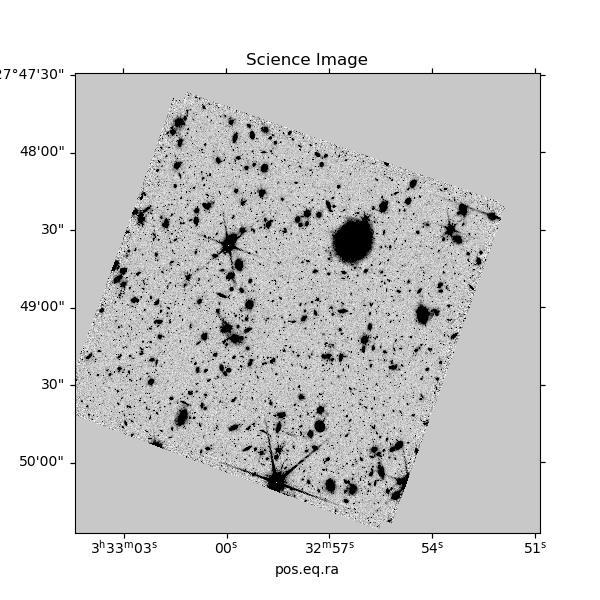

In [104]:
plt.figure(figsize=(6, 6))
plt.subplot(projection=wcs) # Turn on WCS projection
plt.title('Science Image')
plt.imshow(sci, cmap='Greys', norm=norm, origin='lower', interpolation='none')
plt.show()


### 3. Error and weight maps

The science image we just plotted contained the measured fluxes. There are other data products that contain other important information about the science image. These include the error image and weight image, a.k.a. the error map and weight map.

The error map contains the uncertainty of the science image at each pixel. The sources of error include fluctuations of the light from the "background", as well as fluctuation of the light from the sources. This is important in the following steps.

The weight map tells you the "weight" of each pixel. The weight is mostly proportional to the exposure time spent on that pixel. A longer exposure time will give a longer weight.

In [131]:
wht = fits.getdata('ngdeep_nircam_f277w_bkgsub_wht_cutout.fits.gz')
err = fits.getdata('ngdeep_nircam_f277w_bkgsub_err_cutout.fits.gz')

We can create a "mask" to denote areas we do NOT want to use in our photometry. This includes regions where we have no exposure time, or zero weights in the weight map.

In [132]:
mask = wht==0

Generally speaking, the weight map is proportional to the inverse variance of the background noise of the image, i.e. $w \propto 1/\sigma^2$.

The reason is as follows.

Assume the exposure time is $t$. Over that time, the number of background photons collected, or counts, is $N \propto t$.

Photon noise follows Poisson error, which means the error in the counts is $\Delta N = \sqrt N$, which is $\propto \sqrt t$.

The "count rate" or "flux" is defined as $f = N/t$.

The error in the flux is then $\Delta f = \Delta N / t = \sqrt N / t$. As $N \propto t$, we can rewrite this as $\Delta f \propto \sqrt t / t \propto 1/\sqrt t$.

Now, recall the weight is proportional to exposure time, i.e. $w \propto t$.

Voila! The flux error is proportional to $1/ \sqrt w$, or $w \propto 1/ \Delta f ^2$

Next, we create a background error map using the weight map. Note that this background error map is different from the general error map we just read in. The background error map only contains the error from the fluctuation of the background light. The general error map contains both the former and the error from the fluctuation of the source light.

In [133]:
# Create a background error map from the weight
wht2rms = 1/np.sqrt(wht)

/var/folders/bd/zp6pb1_s1b12w9w_0spkmqkjdqyrts/T/ipykernel_8128/646349155.py:2: RuntimeWarning: divide by zero encountered in divide
  wht2rms = 1/np.sqrt(wht)


We have created a background error map using $\Delta f \propto 1/\sqrt w$. We then need to find the proportionality constant for the background error map, i.e. the value of $C$ in $\Delta f = C / \sqrt w$. We do this by finding the average ratio of the general error map to $1 / \sqrt w$ map, then we can scale $1 / \sqrt w$ by this number to reach the correct error level.

Recall that the general error map contains both fluctuations from sources and the background, and we only want the latter. In pixels where there are no sources, it will only contain the background error. Since the majority of the sky is empty space, taking a median will remove the contribution from source pixels.

We can take the median of ratio of the general error map to the $1 / \sqrt w$ map to estimate correct proportionality constant to calculate the error of the sky background.

In [135]:
# Find proportionality constant by taking the median of the ratio bewteen 
# the general error map and the background error map
err_fac = np.median(err[~mask] / wht2rms[~mask])
print(err_fac)

0.53150517


In [136]:
# Apply the proportionality constant
wht2rms *= err_fac

Let's plot out the images to see what they look like. You can see that the general error map conatins higher values at the positions of sources, but the background error map doesn't.

<IPython.core.display.Javascript object>


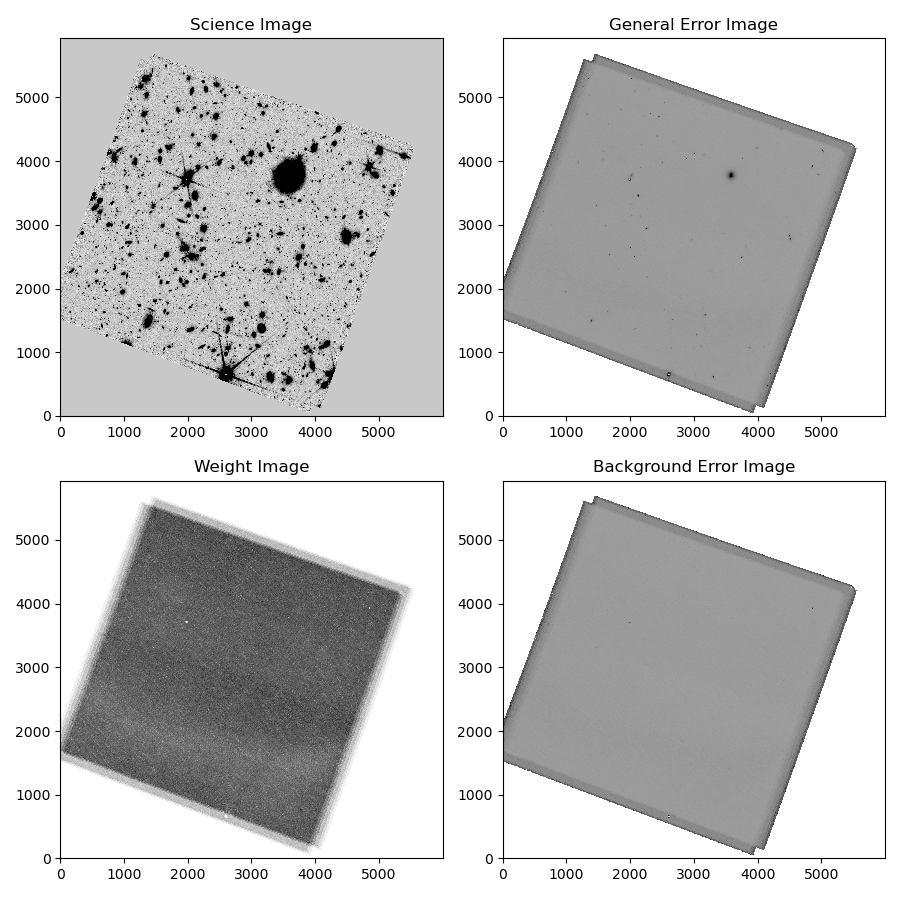

In [216]:
norm = ImageNormalize(sci[mask==0], interval=ZScaleInterval())

plt.figure(figsize=(9, 9))
plt.subplot(221)
plt.title('Science Image')
plt.imshow(sci, cmap='Greys', norm=norm, origin='lower', interpolation='none')

plt.subplot(222)
plt.title('General Error Image')
plt.imshow(err, cmap='Greys', norm=norm, origin='lower', interpolation='none')

plt.subplot(223)
plt.title('Weight Image')
plt.imshow(wht, cmap='Greys', origin='lower', interpolation='none')

plt.subplot(224)
plt.title('Background Error Image')
plt.imshow(wht2rms, cmap='Greys', norm=norm, origin='lower', interpolation='none')

plt.tight_layout()
plt.show()

The background error map is what we need when we move on to detecting sources in the next step.

To detect sources, we look for pixels where the flux is substantially higher than the background error. If we use the general error map instead, positions with sources will have a higher error, making it more difficult to detect the sources.

## Source detection and photometry

Once we have all the science, error and weight images, we can work on detecting sources and measuring fluxes from them.

In [179]:
from astropy.convolution import convolve
from photutils.segmentation import detect_sources
from photutils.segmentation import deblend_sources
from photutils.segmentation import SourceFinder
from photutils.segmentation import SourceCatalog
from photutils.aperture import CircularAperture
from photutils.aperture import aperture_photometry


### 1. Preprocessing the image

Usually, we will slightly smooth the science image to improve source detection. This will smooth out noise fluctuations and make real sources stand out.

To do this, we apply a convolution kernel to the image. This means that the flux in each pixle is "spread out" to the neighboring pixels following the kernel, making the image smoother.

In [138]:
# Read in the convolution kernel
conv = np.loadtxt('tophat_4.0_5x5.conv')
conv

array([[0.  , 0.22, 0.48, 0.22, 0.  ],
       [0.22, 0.99, 1.  , 0.99, 0.22],
       [0.48, 1.  , 1.  , 1.  , 0.48],
       [0.22, 0.99, 1.  , 0.99, 0.22],
       [0.  , 0.22, 0.48, 0.22, 0.  ]])

In [140]:
# Convolve science image with convolution kernel
sci_conv = convolve(sci, conv)

Let's plot out the raw and convolved science images to see the difference.

<IPython.core.display.Javascript object>


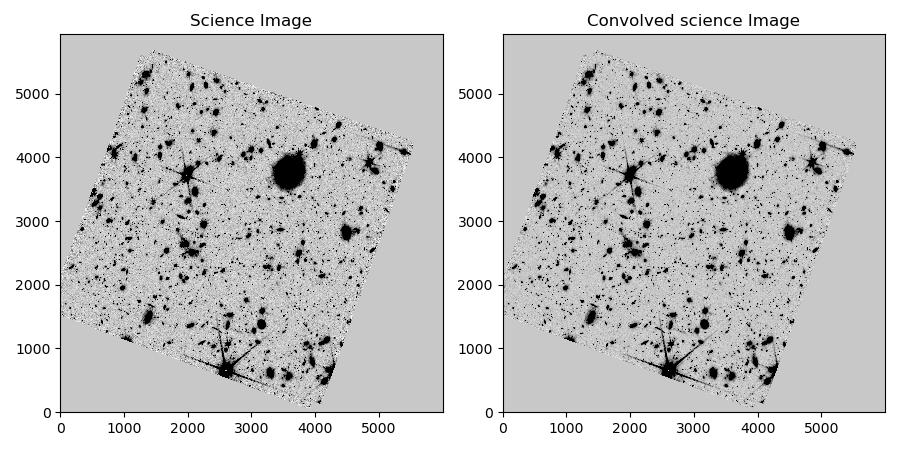

In [215]:
# Plot out raw and convolved science images
plt.figure(figsize=(9, 4.5))
plt.subplot(121)
plt.title('Science Image')
plt.imshow(sci, cmap='Greys', norm=norm, origin='lower', interpolation='none')

plt.subplot(122)
plt.title('Convolved science Image')
plt.imshow(sci_conv, cmap='Greys', norm=norm, origin='lower', interpolation='none')

plt.tight_layout()
plt.show()

### 2. Source detection

Now we can detect sources in the convolved image! Source detection is the process of finding positions in the image where there is significant emission from objects. The basic principles of detecting sources are as follows.

(1) Compare the science image with the background error map. <br>
(2) Select pixels where the flux is higher than the background error by a factor of $\texttt{thresh}$. We'll call them "significant pixels".  <br>
(3) Find areas where more than $\texttt{minarea}$ significant pixels are connected together.  <br>

This gives us regions of significant fluxes where at least $\texttt{minarea}$ connected pixels are higher than the background by a factor of $\texttt{thresh}$. 

We can change $\texttt{thresh}$ and $\texttt{minarea}$ when working with different data sets, as different images will have different properties. Higher $\texttt{thresh}$ and $\texttt{minarea}$ will yield fewer but more significant sources, while lower values will yield a larger number of less significant sources.

Another step in source detection is "deblending". If two sources are close to each other, their light will overlap in the image, creating a large group of connected significant pixels spanning both sources.

Deblending is controlled by two parameters: $\texttt{deblend_cont}$ and $\texttt{deblend_nthresh}$. $\texttt{deblend_cont}$ is a number between 0 and 1. The smaller the number, the more aggresively the deblending will be, i.e., the source will be separating into more components. $\texttt{deblend_cont}=1$ will mean no deblending is performed. $\texttt{deblend_nthresh}$ is somewhat less important. A value of 32 will usually work.

Again, these parameters should be changed when working with different images. There are no optimal parameters that will work for all images. Some experimenting is needed to find the best values that work for your data set.

We will use the $\texttt{photutils}$ package to perform source detection here. Some other source detection and/or photometry packages or software include $\texttt{SourceExtractor}$ and $\texttt{SEP}$.

In [156]:
# We perform source detection using photutils

thresh = 1.6
minarea = 5
deblend_cont = 0.01
deblend_nthresh = 32

# Function that sets up the criteria for selecting sources in our image
finder = SourceFinder(npixels=minarea, nlevels=deblend_nthresh, contrast=deblend_cont)

# Function that actually finds the sources in the imaging and we are finding
# sources that have fluxes greater than 1.6 times the background error fluxes
segment_map = finder(sci_conv, thresh*wht2rms)


Deblending:   0%|          | 0/4885 [00:00<?, ?it/s]

It creates a "segmentation map", which labels the regions of connected significant pixels attributed to the sources detected.

<IPython.core.display.Javascript object>


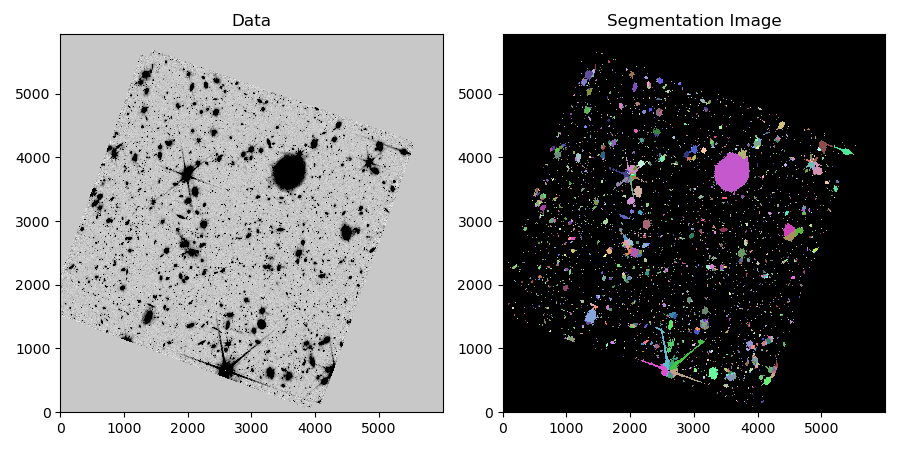

In [214]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4.5))

ax1.imshow(sci_conv, origin='lower', cmap='Greys', norm=norm, interpolation='none')
ax1.set_title('Data')

ax2.imshow(segment_map, origin='lower', cmap=segment_map.cmap, interpolation='none')
ax2.set_title('Segmentation Image')

plt.tight_layout()
plt.show()

### 3. Photometry

Source detection gives us a list of positions where there are sources. We then perform photometry on these sources, which is the process of measuring the amount of light emitted by these sources.

A common method to do so is aperture photometry. The basic concept of aperture photometry is to draw a circular or elliptical aperture around the souce position, and sum up the flux contained therein.

The most basic form of aperture photometry is using circular apertures of fixed radii. While this is simple, a drawback is that different sources have different sizes and shapes. So circular apertures of fixed radii will capture different fraction of light from different sources.

A more advance form of aperture photometry uses the Kron aperture. Kron et al. (1980) outlines a method to compute elliptical apertures depending on the actual size and shape of the source, aiming to capture a more uniform fraction of light in the aperture for a wide range of sources.

This is be easily done using $\texttt{photutils}$.

In [212]:
cat = SourceCatalog(data=sci, segment_img=segment_map, convolved_data=sci_conv, error=err, wcs=wcs)
print(cat)

<photutils.segmentation.catalog.SourceCatalog>
Length: 6814
labels: [   1    2    3    4    5 ... 6810 6811 6812 6813 6814]


In [213]:
# Make an astropy table from the results and list the columns
### This may take a few seconds to run ###

tbl = cat.to_table()
print(tbl.columns)


<TableColumns names=('label','xcentroid','ycentroid','sky_centroid','bbox_xmin','bbox_xmax','bbox_ymin','bbox_ymax','area','semimajor_sigma','semiminor_sigma','orientation','eccentricity','min_value','max_value','local_background','segment_flux','segment_fluxerr','kron_flux','kron_fluxerr')>


Next, lets plot out the sources and see where they are in the image. It will look a bit crowded. When you zoom in, it will make a lot more sense.

At this step, we want to check two things. (1) Are there sources in the image that are visible by your eyes, but not detected? (2) Are there places where a sources is detected but you don't see anything in the image?

If the former is true, go back and try decreasing $\texttt{thresh}$ and/or $\texttt{minarea}$. If the latter is true, try increasing the values.

Also, check for the quality of deblending. If a source is divided into too many components, try increasing $\texttt{deblend_cont}$. If sources are not deblended enough, trying lower the value instead.

<IPython.core.display.Javascript object>


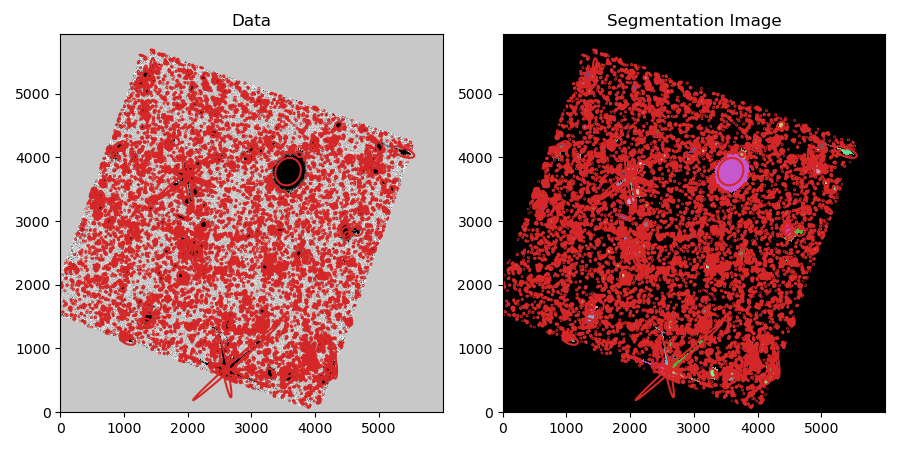

In [211]:
### This may take a few seconds to run ###

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4.5))

ax1.imshow(sci, origin='lower', cmap='Greys', norm=norm, interpolation='none')
ax1.set_title('Data')

ax2.imshow(segment_map, origin='lower', cmap=segment_map.cmap, interpolation='none')
ax2.set_title('Segmentation Image')

cat.plot_kron_apertures(ax=ax1, color='C3', lw=1.5)
cat.plot_kron_apertures(ax=ax2, color='C3', lw=1.5)

plt.tight_layout()
plt.show()

Let's print out the fluxes extracted using Kron aperture.

In [170]:
tbl['kron_flux']

4.329293603757617
0.2959996067849513
0.5338665682548887
0.25264563909842863
0.6859888440996325
3.383422206316968
0.3800276192626182
0.42306893969280546
1.9561171912125332
...
1.8507214252425073


We can also use $\texttt{photutils}$ to perform circular aperture photometry.

In [192]:
# The CiruclarAperture class in photutils take input of positions as 
# numpy arrays of (x, y) pairs, so we create an array of pairs here.

positions = np.array([tbl['xcentroid'], tbl['ycentroid']]).T

# Note the .T at the end to transpose [[x1, x2, ..., xn], [y1, y2, ..., yn]]
# into [[x1, y1], [x2, y2], ..., [xn, yn]]


In [189]:
# This creates a single aperture for each source with radius of 5 pixels
aperture = CircularAperture(positions, r=5)


In [190]:
# This creates a list of apertures for each source with radii of 2, 4, 6, 8, 10 pixels
apertures = [CircularAperture(positions, r=r) for r in [2, 4, 6, 8, 10]]


In [210]:
# Perform aperture photometry. It will return the output in an astropy table
### This may take a few seconds to run ###

phot_table = aperture_photometry(sci, apertures)
phot_table


id,xcenter,ycenter,aperture_sum_0,aperture_sum_1,aperture_sum_2,aperture_sum_3,aperture_sum_4
,pix,pix,,,,,
int64,float64,float64,float64,float64,float64,float64,float64
1,3901.640428085485,82.43028906043627,0.6778726553785046,1.9153013936459355,2.870573302955406,3.4861995733531463,3.8485725047081325
2,3872.9751310263696,93.48577870742017,0.09440932369759722,0.22170123009196094,0.2864752664063752,0.3413653083124131,0.3787700336220533
3,3912.705179542671,93.3146618808843,0.115699873132717,0.2855594088870826,0.4388378732599285,0.6139216485765939,0.8811886386424597
4,3923.316113063301,110.64247423214549,0.16147420958352465,0.2814802364705569,0.23791558245010663,0.2838756104798489,-0.038596986870442274
5,3857.2653122425454,126.8287027901449,0.17021671083563328,0.42998529554762926,0.562998397858459,0.6219904205153457,0.677000649243372
6,3808.13019204439,131.2800592869275,0.45260374884280247,1.322529134294721,2.012056954618001,2.453046574902574,2.7488945016461104
...,...,...,...,...,...,...,...
7050,1844.233406552542,5536.9748321934385,0.37238522686762704,1.0652676942321175,1.5132904027178773,1.7559526537899557,1.9966397464472843


### 4. Half-light radius

An important quantity in photometry is the "half-light radius". It is the radius that conatins half of the light of a source. This quantifies how extended a source is.

$\texttt{photutils}$ has a function $\texttt{fluxfrac_radius}$ to do this. It calculates the radius that contains a given fraction of light of the source. When set to 0.5, it gives the half-light radius.

In [159]:
rh = cat.fluxfrac_radius(0.5) 
# You can replace 0.5 with any numbers from 0 to 1 to calculate flux radius containing that fraction of light
rh

<Quantity [4.45381685, 2.73843877, 3.75071317, ..., 4.73671875, 9.60514871,
           4.77991037] pix>

In [ ]:
# Add the half-light radius to the catalog table
tbl['rh'] = rh

### 5. Photometric catalog

After we have our photometry, we will write the results in a catalog.

Before doing so, we make some minor formatting changes to the catalog. By default, $\texttt{photutils}$ gives sky coordaintes in the format of $\texttt{astropy}$ $\texttt{SkyCoord}$ objects. 

In [160]:
tbl['sky_centroid']

<SkyCoord (ICRS): (ra, dec) in deg
    [(53.23166444, -27.84023016), (53.23193449, -27.84013782),
     (53.23156007, -27.84013954), ..., (53.25459416, -27.79359651),
     (53.25465267, -27.79357707), (53.25478502, -27.7935395 )]>

However, if this is written to a file in text or fits format, it will simply be converted to a string, losing its $\texttt{SkyCoord}$ properties. So we will just extract the RA and Dec and write them as floats in two columns.

In [205]:
tbl['ra'] = tbl['sky_centroid'].ra
tbl['dec'] = tbl['sky_centroid'].dec
tbl.remove_column('sky_centroid')

We will also add the circular aperture results in the catalog using the $\texttt{astropy.table.join}$ function.

In [206]:
tbl = join(tbl, phot_table, keys_left='label', keys_right='id')

# Remove some redundant columns
tbl.remove_columns(['xcenter', 'ycenter', 'label'])

This is our final photometric catalog!

In [209]:
tbl

xcentroid,ycentroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr,ra,dec,id,aperture_sum_0,aperture_sum_1,aperture_sum_2,aperture_sum_3,aperture_sum_4
,,,,,,pix2,pix,pix,deg,,,,,,,,,deg,deg,,,,,,
float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64
3901.640428085485,82.43028906043627,3895,3910,76,89,162.0,3.618643152142861,2.4434562309802943,48.410353756263234,0.7375971719583294,0.004351445369475858,0.06563309978172777,0.0,3.3677004270606847,0.056966808,4.329293603757617,0.106397209465989,53.23166443983965,-27.84023016226218,1,0.6778726553785046,1.9153013936459355,2.870573302955406,3.4861995733531463,3.8485725047081325
3872.9751310263696,93.48577870742017,3872,3874,92,95,12.0,1.0878860591607684,0.8003739366450461,-87.81036614766295,0.677291406207569,0.006052489953580685,0.010178707542336544,0.0,0.09382968812525025,0.011272643,0.2959996067849513,0.03827042842797904,53.23193449228954,-27.840137821061465,2,0.09440932369759722,0.22170123009196094,0.2864752664063752,0.3413653083124131,0.3787700336220533
3912.705179542671,93.3146618808843,3911,3914,92,95,12.0,1.224480315557491,0.7199257254297184,45.24875178805146,0.8089017103186374,0.007184715242216807,0.010696772771858617,0.0,0.11455257400789458,0.014703212,0.5338665682548887,0.060500339249326934,53.23156007347842,-27.840139541168195,3,0.115699873132717,0.2855594088870826,0.4388378732599285,0.6139216485765939,0.8811886386424597
3923.316113063301,110.64247423214549,3922,3924,109,113,10.0,1.4673070632240415,0.6950400939226751,75.32607172142656,0.8806947991999253,0.001298954887814272,0.018588929623666775,0.0,0.13822258841665394,0.015008747,0.25264563909842863,nan,53.231459930373504,-27.839995221431373,4,0.16147420958352465,0.2814802364705569,0.23791558245010663,0.2838756104798489,-0.038596986870442274
3857.2653122425454,126.8287027901449,3854,3860,123,131,49.0,2.0148646218839406,1.5889015110530595,-62.063024932731494,0.6149197238528289,0.002842829482439021,0.019095518138484934,0.0,0.43161659518504136,0.0190088,0.6859888440996325,0.04594897814938517,53.232082263609165,-27.83985984738542,5,0.17021671083563328,0.42998529554762926,0.562998397858459,0.6219904205153457,0.677000649243372
3808.13019204439,131.2800592869275,3800,3818,125,137,188.0,3.7932037642198972,2.540292312293339,-1.7233978372197851,0.7426356087938313,0.002107092363334269,0.04317409935554838,0.0,2.4430138687048526,0.035588708,3.383422206316968,0.07673059756026195,53.2325452795533,-27.83982238717688,6,0.45260374884280247,1.322529134294721,2.012056954618001,2.453046574902574,2.7488945016461104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1844.233406552542,5536.9748321934385,1840,1848,5531,5541,74.0,2.529064260091414,1.8791234369885057,89.10527939088126,0.669278821935394,0.006704293297044148,0.04012922487995985,0.0,1.35087359851928,0.03867437,1.6699882113344944,nan,53.25099999543172,-27.794759167843083,6809,0.35467348661301046,1.1436090804380368,2.0357189644455316,2.884568681226578,3.6588578505790097


If everything looks right, we will write it out!

In [96]:
# Write catalog in fits format
tbl.write('source_catalog.fits', overwrite=True)

In [ ]:
# We can also write it in ascii format
tbl.write('source_catalog.txt', format='ascii', overwrite=True)